In [1]:
import torch
import torch.nn as nn
from lib2to3.pgen2 import token
from tracemalloc import start
import numpy as np
import csv
import keras
from sklearn.utils import shuffle 
import time as tt
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
np.random.seed(1)
device = 'cuda'
torch.set_default_tensor_type('torch.cuda.FloatTensor')

def runtime(starttime):
    ret = tt.time() - starttime
    return ret

def unison_shuffle(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

def load_pretrained_embeddings(filepath):
    print("Loading in pretrained GloVe embeddings from: {}".format(filepath))
    
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as embedfile:
        for line in embedfile:
            split_line = line.split()
            token = split_line[0]
            embed = np.array(split_line[1:], dtype=np.float64)
            embeddings[token] = embed
    
    print("{} words loaded into embedding".format(len(embeddings)))
    
    return (embeddings)

def tokenize_csv(filename):
    sen=[]
    lab=[]

    with open(filename, mode='r',encoding='utf-8') as csvfile:
        tweetreader = csv.reader(csvfile)
        firstline=True
        for sentence, label in tweetreader:
            if firstline:
                firstline=False
                continue
            else:
                sen.append(keras.preprocessing.text.text_to_word_sequence(sentence.encode('ascii', 'ignore').decode('ascii')))
                if label=='sadness':
                    lab.append([0,0,0,0,1])
                elif label=='happiness':
                    lab.append([0,0,0,1,0])
                elif label=='no emotion':
                    lab.append([0,0,1,0,0])
                elif label=='fear':
                    lab.append([0,1,0,0,0])
                else:
                    lab.append([1,0,0,0,0])

    return (sen, lab)

def tokenize_manual(filename, label):
    '''
        00001 sadness 
        00010 happiness
        00100 no emotion
        01000 fear
        10000 anger
    '''

    sen=[]
    lab=[]
    with open(filename, mode='r', encoding='utf-8') as csvfile:
        treader=csv.reader(csvfile)
        firstline=True
        for i_d, t in treader:
            if firstline:
                firstline=False
                continue
            else:
                sen.append(keras.preprocessing.text.text_to_word_sequence(t.encode('ascii', 'ignore').decode('ascii')))
                lab.append(label)
    
    return (sen, lab)

def tweet_vectorize(tweet_label_in, glove_embeds):
    out_vectors = []

    tweet_list = tweet_label_in[0]
    label_list = tweet_label_in[1]

    for i in range(len(tweet_list)):
        curr_tweet = []
        while len(tweet_list[i]) > 0 and len(curr_tweet) < 50:
            curr_word = tweet_list[i].pop(0)
            if curr_word in glove_embeds:
                curr_tweet.append(glove_embeds[curr_word])
            else:
                curr_tweet.append(np.zeros(50))     # dimensionality of embedding vector
        if len(curr_tweet) < 50:
            while len(curr_tweet) < 50:
                curr_tweet.append(np.zeros(50))
        out_vectors.append(curr_tweet)
    
    return (out_vectors, label_list)

def split_train_val_test(input, labels, man_input, man_lab):

  input_shuff, labels_shuff = shuffle(input, labels)

  training_proportion = 0.8
  validation_proportion = 0.1
  num_train = int(len(input_shuff) * training_proportion)
  num_val = int(len(input_shuff) * validation_proportion)

  input_train, input_valid, input_test = input_shuff[:num_train], input_shuff[num_train:num_train+num_val], input_shuff[num_train+num_val:]
  label_train, label_valid, label_test = labels_shuff[:num_train], labels_shuff[num_train:num_train+num_val], labels_shuff[num_train+num_val:]

  input_test += man_input
  label_test += man_lab

  return input_train, input_valid, input_test, label_train, label_valid, label_test

def convert_to_tensors(input_train, input_valid, input_test, label_train, label_valid, label_test):
  input_train = torch.as_tensor(input_train)
  input_valid = torch.as_tensor(input_valid)
  input_test = torch.as_tensor(input_test)
  label_train = torch.as_tensor(label_train)
  label_valid = torch.as_tensor(label_valid)
  label_test = torch.as_tensor(label_test)

  return input_train, input_valid, input_test, label_train, label_valid, label_test

def accuracy_calc(predictions, labels):
    prediction = torch.argmax(predictions, dim=1)
    prediction = nn.functional.one_hot(prediction, num_classes=5)
    ret = torch.unique(prediction[prediction == labels], return_counts=True)
    if ret[0][-1] == 1: ret = float(ret[1][1]/len(labels))
    else: ret = 0.0
    return ret

# Model Definition
class model(nn.Module):
    def __init__(self, in_channels=50, out_channels=50, kernel_size=3, stride=1, hidden_dim=4, num_layers=1):
        super(model, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.convolution_layer1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride),      # IN: [batch_size, num_vecs=50, embed_dim=50], OUT: [batch_size, out_channel=50, convolved=48]
            nn.BatchNorm1d(out_channels),                                   # unchanged; in-place op
            nn.ReLU(),                                                      # unchanged; in-place ops
            nn.MaxPool1d(kernel_size))                                      # IN: [batch_size, out_channel=50, convolved=48], OUT: [batch_size, 50, floor(convolved/kernel_size)=16]

        self.bilstm = nn.LSTM(input_size=int((self.in_channels - self.kernel_size + 1)/self.kernel_size), hidden_size=hidden_dim, bidirectional=True, num_layers=num_layers)   # IN: [batch_size, 50, 16], OUT: [batch_size, 50, 8]

        self.lin1 = nn.Linear(out_channels, 1)
        self.lin2 = nn.Linear(8, 5)     # whatever the 2nd of bilstm out is

        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        x = self.convolution_layer1(x)
        x, (hn, cn) = self.bilstm(x)
        x = torch.transpose(x, 1, 2)
        x = self.lin1(x)
        x = torch.transpose(x, 1, 2)
        x = self.lin2(x)
        x = self.softmax(x)
        return(x)

# training loop
def training_loop(model_instance, loss, optimizer, epochs, batch_size, x_train, y_train):
  for epoch in range(epochs):
    prediction = model_instance(x_train)
    print(prediction.shape)
    loss_value = loss(prediction, y_train)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()


In [3]:
runstart = tt.time()
small_embeds = load_pretrained_embeddings("D:/OneDrive - University of Toronto/School/NSCI Y3/WINTER/ECE324/glove.6B/glove.6B.50d.txt")

Loading in pretrained GloVe embeddings from: D:/OneDrive - University of Toronto/School/NSCI Y3/WINTER/ECE324/glove.6B/glove.6B.50d.txt
400000 words loaded into embedding


In [4]:
training_set = [[], []]
for i in range(1, 6):
    train_tokens = tokenize_csv("D:/OneDrive - University of Toronto/School/NSCI Y3/WINTER/ECE324/tweet_emotion/tweets_labels/data{}.csv".format(str(i)))
    temp_vec = tweet_vectorize(train_tokens, small_embeds)
    training_set[0] = training_set[0] + temp_vec[0]
    training_set[1] = training_set[1] + temp_vec[1]
    print('Finished vectorizing csv number {}'.format(str(i)), "Dataset size: ", len(training_set[0]), len(training_set[1]))

manual_names = ['anger', 'fear', 'happy', 'sad']
manual_labels = [[1,0,0,0,0], [0,1,0,0,0], [0,0,0,1,0], [0,0,0,0,1]]

manual_set = [[], []]
for i in range(len(manual_labels)):
    manual_tokens = tokenize_manual("D:/OneDrive - University of Toronto/School/NSCI Y3/WINTER/ECE324/tweet_emotion/manually_labeled/data_{}.csv".format(manual_names[i]), manual_labels[i])
    temp_vec = tweet_vectorize(manual_tokens, small_embeds)
    manual_set[0] = manual_set[0] + temp_vec[0]
    manual_set[1] = manual_set[1] + temp_vec[1]

Finished vectorizing csv number 1 Dataset size:  28091 28091
Finished vectorizing csv number 2 Dataset size:  65180 65180
Finished vectorizing csv number 3 Dataset size:  104505 104505
Finished vectorizing csv number 4 Dataset size:  143588 143588
Finished vectorizing csv number 5 Dataset size:  207863 207863


In [5]:
x_train, x_valid, x_test, y_train, y_valid, y_test = split_train_val_test(training_set[0], training_set[1], manual_set[0], manual_set[1])
x_train, x_valid, x_test, y_train, y_valid, y_test = convert_to_tensors(x_train, x_valid, x_test, y_train, y_valid, y_test)

C:\Users\garyx\AppData\Local\Temp/ipykernel_12124/1591375611.py:117: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  input_train = torch.as_tensor(input_train)


#### Initial tested parameters
Training params: epochs = 10, learning rate = 0.001, batch size = 10000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 30, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train & Valid accuracy w/ params: 60.4906% & 60.3420%

#### Tuning tested parameters
Training params: epochs = 10, learning rate = 0.0001, batch size = 5000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 30, kernel_size = 5, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy w/ params: 60.0988, 60.2081, 59.4562

Training params: epochs = 10, learning rate = 0.001, batch size = 10000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy accuracy w/ params: 60.5603%, 60.5773%, 60.395527%

Training params: epochs = 10, learning rate = 0.001, batch size = 10000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 2 <br/>
Train Valid Test accuracy accuracy w/ params: 60.0768%, 60.0725%, 59.479868%

Training params: epochs = 100, learning rate = 0.001, batch size = 1000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy accuracy w/ params: 69.5821%, 66.4842%, 65.8611% |||| Took ~24 min

Training params: epochs = 50, learning rate = 0.001, batch size = 1000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy accuracy w/ params: 68.7802%, 65.6326%, 65.2617% |||| Took ~12 min

In [8]:
start = tt.time()

y_train = torch.squeeze(y_train, dim=1)
y_valid = torch.squeeze(y_valid, dim=1)
y_test = torch.squeeze(y_test, dim=1)

model_instance = model()

# Training hyperparams
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model_instance.parameters(), lr=0.001)
batch_size = 1000
num_epochs = 50

epoch_acc = []
epoch_loss = []

curr_iter = 0
for epoch in tqdm(range(int(num_epochs)), desc='Training Epochs'):
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []

    for b in range(0, len(x_train), batch_size):
        x_batch = x_train[b:b+batch_size]
        y_batch = y_train[b:b+batch_size]

        prediction = model_instance(x_batch)
        prediction = torch.squeeze(prediction, dim=1)
        y_batch = y_batch.type(torch.cuda.FloatTensor)
        loss_value = loss(prediction, y_batch)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_acc.append(accuracy_calc(prediction, y_batch))
        train_loss.append(loss_value.item())
        
    train_loss = np.asarray(train_loss)
    train_acc = np.asarray(train_acc)
    epoch_loss.append(np.mean(train_loss))
    epoch_acc.append(100*np.mean(train_acc))

    for b in range(0, len(x_valid), batch_size):
        x_batch = x_valid[b:b+batch_size]
        y_batch = y_valid[b:b+batch_size]

        prediction = model_instance(x_batch)
        prediction = torch.squeeze(prediction, dim=1)
        y_batch = y_batch.type(torch.cuda.FloatTensor)
        loss_value = loss(prediction, y_batch)

        valid_acc.append(accuracy_calc(prediction, y_batch))
        valid_loss.append(loss_value.item())

    valid_loss = np.asarray(valid_loss)
    valid_acc = np.asarray(valid_acc)
    
    print("Train Loss: {:.4f}\t\t".format(epoch_loss[-1])) 
    print("Train Acc: {:.4f}%\t".format(epoch_acc[-1]))
    print("Valid Loss: {:.4f}\t\t".format(np.mean(valid_loss))) 
    print("Valid Acc: {:.4f}%\t".format(100*np.mean(valid_acc)))

print("Total training runtime: {:2f}".format(runtime(start)))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\garyx\AppData\Local\Temp/ipykernel_12124/1591375611.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
Training Epochs:   2%|▏         | 1/50 [00:17<13:53, 17.01s/it]

Train Loss: 0.3784		
Train Acc: 60.0901%	
Valid Loss: 0.3542		
Valid Acc: 60.5527%	


Training Epochs:   4%|▍         | 2/50 [00:35<14:13, 17.78s/it]

Train Loss: 0.3386		
Train Acc: 62.1128%	
Valid Loss: 0.3258		
Valid Acc: 63.8993%	


Training Epochs:   6%|▌         | 3/50 [00:53<14:03, 17.96s/it]

Train Loss: 0.3207		
Train Acc: 64.1210%	
Valid Loss: 0.3184		
Valid Acc: 64.2292%	


Training Epochs:   8%|▊         | 4/50 [01:11<13:49, 18.03s/it]

Train Loss: 0.3149		
Train Acc: 64.5997%	
Valid Loss: 0.3146		
Valid Acc: 64.5166%	


Training Epochs:  10%|█         | 5/50 [01:29<13:32, 18.06s/it]

Train Loss: 0.3110		
Train Acc: 64.9841%	
Valid Loss: 0.3117		
Valid Acc: 64.8158%	


Training Epochs:  12%|█▏        | 6/50 [01:47<13:16, 18.11s/it]

Train Loss: 0.3077		
Train Acc: 65.3325%	
Valid Loss: 0.3094		
Valid Acc: 65.0231%	


Training Epochs:  14%|█▍        | 7/50 [02:05<12:57, 18.09s/it]

Train Loss: 0.3047		
Train Acc: 65.6201%	
Valid Loss: 0.3075		
Valid Acc: 65.2820%	


Training Epochs:  16%|█▌        | 8/50 [02:24<12:46, 18.25s/it]

Train Loss: 0.3023		
Train Acc: 65.8860%	
Valid Loss: 0.3062		
Valid Acc: 65.3976%	


Training Epochs:  18%|█▊        | 9/50 [02:42<12:28, 18.25s/it]

Train Loss: 0.3003		
Train Acc: 66.0839%	
Valid Loss: 0.3053		
Valid Acc: 65.4703%	


Training Epochs:  20%|██        | 10/50 [03:01<12:09, 18.23s/it]

Train Loss: 0.2987		
Train Acc: 66.2415%	
Valid Loss: 0.3045		
Valid Acc: 65.3776%	


Training Epochs:  22%|██▏       | 11/50 [03:18<11:44, 18.07s/it]

Train Loss: 0.2973		
Train Acc: 66.3802%	
Valid Loss: 0.3040		
Valid Acc: 65.5266%	


Training Epochs:  24%|██▍       | 12/50 [03:35<11:06, 17.55s/it]

Train Loss: 0.2960		
Train Acc: 66.5666%	
Valid Loss: 0.3034		
Valid Acc: 65.5421%	


Training Epochs:  26%|██▌       | 13/50 [03:49<10:18, 16.71s/it]

Train Loss: 0.2949		
Train Acc: 66.7322%	
Valid Loss: 0.3036		
Valid Acc: 65.4668%	


Training Epochs:  28%|██▊       | 14/50 [04:04<09:38, 16.06s/it]

Train Loss: 0.2940		
Train Acc: 66.8710%	
Valid Loss: 0.3034		
Valid Acc: 65.4170%	


Training Epochs:  30%|███       | 15/50 [04:19<09:10, 15.72s/it]

Train Loss: 0.2931		
Train Acc: 66.9734%	
Valid Loss: 0.3031		
Valid Acc: 65.5114%	


Training Epochs:  32%|███▏      | 16/50 [04:34<08:46, 15.47s/it]

Train Loss: 0.2921		
Train Acc: 67.1131%	
Valid Loss: 0.3029		
Valid Acc: 65.4564%	


Training Epochs:  34%|███▍      | 17/50 [04:48<08:21, 15.21s/it]

Train Loss: 0.2913		
Train Acc: 67.1832%	
Valid Loss: 0.3030		
Valid Acc: 65.3352%	


Training Epochs:  36%|███▌      | 18/50 [05:03<07:57, 14.91s/it]

Train Loss: 0.2907		
Train Acc: 67.3150%	
Valid Loss: 0.3028		
Valid Acc: 65.4387%	


Training Epochs:  38%|███▊      | 19/50 [05:17<07:38, 14.77s/it]

Train Loss: 0.2900		
Train Acc: 67.3500%	
Valid Loss: 0.3024		
Valid Acc: 65.6863%	


Training Epochs:  40%|████      | 20/50 [05:32<07:20, 14.69s/it]

Train Loss: 0.2892		
Train Acc: 67.4613%	
Valid Loss: 0.3024		
Valid Acc: 65.7127%	


Training Epochs:  42%|████▏     | 21/50 [05:46<07:02, 14.56s/it]

Train Loss: 0.2886		
Train Acc: 67.5631%	
Valid Loss: 0.3022		
Valid Acc: 65.7019%	


Training Epochs:  44%|████▍     | 22/50 [06:00<06:45, 14.49s/it]

Train Loss: 0.2880		
Train Acc: 67.6062%	
Valid Loss: 0.3023		
Valid Acc: 65.6759%	


Training Epochs:  46%|████▌     | 23/50 [06:14<06:29, 14.41s/it]

Train Loss: 0.2875		
Train Acc: 67.6709%	
Valid Loss: 0.3021		
Valid Acc: 65.6577%	


Training Epochs:  48%|████▊     | 24/50 [06:29<06:12, 14.34s/it]

Train Loss: 0.2876		
Train Acc: 67.7000%	
Valid Loss: 0.3024		
Valid Acc: 65.6374%	


Training Epochs:  50%|█████     | 25/50 [06:43<05:57, 14.31s/it]

Train Loss: 0.2870		
Train Acc: 67.7565%	
Valid Loss: 0.3020		
Valid Acc: 65.7313%	


Training Epochs:  52%|█████▏    | 26/50 [06:57<05:42, 14.27s/it]

Train Loss: 0.2864		
Train Acc: 67.8768%	
Valid Loss: 0.3028		
Valid Acc: 65.4863%	


Training Epochs:  54%|█████▍    | 27/50 [07:11<05:27, 14.24s/it]

Train Loss: 0.2869		
Train Acc: 67.8071%	
Valid Loss: 0.3021		
Valid Acc: 65.6776%	


Training Epochs:  56%|█████▌    | 28/50 [07:25<05:13, 14.24s/it]

Train Loss: 0.2862		
Train Acc: 67.9020%	
Valid Loss: 0.3020		
Valid Acc: 65.7681%	


Training Epochs:  58%|█████▊    | 29/50 [07:40<04:58, 14.23s/it]

Train Loss: 0.2856		
Train Acc: 68.0104%	
Valid Loss: 0.3023		
Valid Acc: 65.7192%	


Training Epochs:  60%|██████    | 30/50 [07:54<04:44, 14.22s/it]

Train Loss: 0.2851		
Train Acc: 68.0338%	
Valid Loss: 0.3026		
Valid Acc: 65.8123%	


Training Epochs:  62%|██████▏   | 31/50 [08:08<04:29, 14.21s/it]

Train Loss: 0.2847		
Train Acc: 68.0978%	
Valid Loss: 0.3023		
Valid Acc: 65.7062%	


Training Epochs:  64%|██████▍   | 32/50 [08:22<04:16, 14.23s/it]

Train Loss: 0.2842		
Train Acc: 68.1370%	
Valid Loss: 0.3024		
Valid Acc: 65.7253%	


Training Epochs:  66%|██████▌   | 33/50 [08:36<04:01, 14.23s/it]

Train Loss: 0.2838		
Train Acc: 68.2214%	
Valid Loss: 0.3025		
Valid Acc: 65.7132%	


Training Epochs:  68%|██████▊   | 34/50 [08:51<03:47, 14.23s/it]

Train Loss: 0.2834		
Train Acc: 68.2764%	
Valid Loss: 0.3026		
Valid Acc: 65.6573%	


Training Epochs:  70%|███████   | 35/50 [09:05<03:33, 14.22s/it]

Train Loss: 0.2831		
Train Acc: 68.2904%	
Valid Loss: 0.3027		
Valid Acc: 65.6919%	


Training Epochs:  72%|███████▏  | 36/50 [09:19<03:18, 14.21s/it]

Train Loss: 0.2828		
Train Acc: 68.3425%	
Valid Loss: 0.3028		
Valid Acc: 65.6980%	


Training Epochs:  74%|███████▍  | 37/50 [09:33<03:04, 14.20s/it]

Train Loss: 0.2825		
Train Acc: 68.3716%	
Valid Loss: 0.3029		
Valid Acc: 65.7872%	


Training Epochs:  76%|███████▌  | 38/50 [09:48<02:50, 14.23s/it]

Train Loss: 0.2823		
Train Acc: 68.3983%	
Valid Loss: 0.3029		
Valid Acc: 65.7408%	


Training Epochs:  78%|███████▊  | 39/50 [10:02<02:36, 14.22s/it]

Train Loss: 0.2820		
Train Acc: 68.4566%	
Valid Loss: 0.3029		
Valid Acc: 65.7564%	


Training Epochs:  80%|████████  | 40/50 [10:16<02:22, 14.22s/it]

Train Loss: 0.2818		
Train Acc: 68.5123%	
Valid Loss: 0.3030		
Valid Acc: 65.8257%	


Training Epochs:  82%|████████▏ | 41/50 [10:30<02:07, 14.22s/it]

Train Loss: 0.2816		
Train Acc: 68.5554%	
Valid Loss: 0.3030		
Valid Acc: 65.7802%	


Training Epochs:  84%|████████▍ | 42/50 [10:44<01:53, 14.21s/it]

Train Loss: 0.2814		
Train Acc: 68.5799%	
Valid Loss: 0.3031		
Valid Acc: 65.7789%	


Training Epochs:  86%|████████▌ | 43/50 [10:59<01:39, 14.20s/it]

Train Loss: 0.2811		
Train Acc: 68.6319%	
Valid Loss: 0.3032		
Valid Acc: 65.7456%	


Training Epochs:  88%|████████▊ | 44/50 [11:13<01:25, 14.21s/it]

Train Loss: 0.2809		
Train Acc: 68.6602%	
Valid Loss: 0.3033		
Valid Acc: 65.7586%	


Training Epochs:  90%|█████████ | 45/50 [11:27<01:11, 14.20s/it]

Train Loss: 0.2808		
Train Acc: 68.6937%	
Valid Loss: 0.3034		
Valid Acc: 65.7504%	


Training Epochs:  92%|█████████▏| 46/50 [11:41<00:56, 14.20s/it]

Train Loss: 0.2806		
Train Acc: 68.6934%	
Valid Loss: 0.3034		
Valid Acc: 65.6824%	


Training Epochs:  94%|█████████▍| 47/50 [11:55<00:42, 14.19s/it]

Train Loss: 0.2804		
Train Acc: 68.7299%	
Valid Loss: 0.3035		
Valid Acc: 65.6802%	


Training Epochs:  96%|█████████▌| 48/50 [12:09<00:28, 14.18s/it]

Train Loss: 0.2802		
Train Acc: 68.7367%	
Valid Loss: 0.3036		
Valid Acc: 65.6456%	


Training Epochs:  98%|█████████▊| 49/50 [12:24<00:14, 14.17s/it]

Train Loss: 0.2800		
Train Acc: 68.7601%	
Valid Loss: 0.3037		
Valid Acc: 65.6720%	


Training Epochs: 100%|██████████| 50/50 [12:38<00:00, 15.17s/it]

Train Loss: 0.2799		
Train Acc: 68.7802%	
Valid Loss: 0.3038		
Valid Acc: 65.6326%	
Total training runtime: 758.270429


In [9]:
# Test accuracy:
prediction = model_instance(x_test)
prediction = torch.squeeze(prediction, dim=1)
test_acc = accuracy_calc(prediction, y_test)
print("Test acc: {:4f}%".format(100*test_acc))

C:\Users\garyx\AppData\Local\Temp/ipykernel_12124/1591375611.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Test acc: 65.261716%


Text(0.5, 1.0, 'Model Training Loss over 50 Epochs')

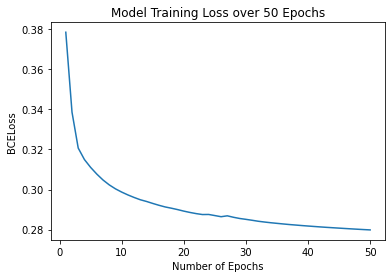

In [10]:
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('BCELoss')
plt.title('Model Training Loss over 50 Epochs')

Text(0.5, 1.0, 'Model Training Accuracy over 50 Epochs')

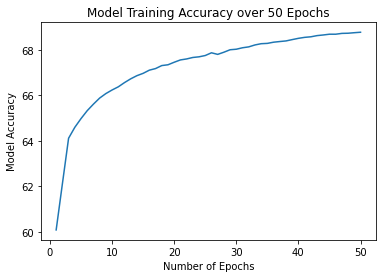

In [11]:
plt.plot(range(1, len(epoch_acc) + 1), epoch_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Model Accuracy')
plt.title('Model Training Accuracy over 50 Epochs')